In [101]:
from sklearn.datasets import load_iris
import numpy as np 
import matplotlib.pyplot as plt

In [57]:
# 定义所需函数
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))
    return x

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 在监督标签为one-hot-vector的情况下，转换为正确解标签的索引
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


In [58]:
# 将每一层类化
class Sigmoid:
    def __init__(self):
        self.params = []
        self.grads = []
        self.out = None 
        
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out 
    
    def backward(self, dout):
        dx = dout * (1 - self.out) * self.out  # dx = y(1-y)
        return dx

In [59]:
class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        W, b = self.params
        dW = np.dot(self.x.T, dout)
        dx = np.dot(dout, W.T)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx

In [60]:

class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax的输出
        self.t = None  # 监督标签

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 在监督标签为one-hot向量的情况下，转换为正确解标签的索引
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

In [61]:
class SGD:
    def __init__(self, lr = 0.001):
        self.lr = lr 
    def update(self, params, grads):
        for i in range (len(params)):
            params[i] -= self.lr * grads[i]

In [97]:
# 搭建整个网络模型
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size
        
        W1 = np.random.randn(I,H)
        b1 = np.zeros(H)
        W2 = np.random.randn(H,O)
        b2 = np.zeros(O)
        
        self.layers = [
            Affine(W1, b1),
            Sigmoid(),
            Affine(W2, b2)
        ]
        
        self.loss_layer = SoftmaxWithLoss()
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def forward(self, x, t):
        score = self.predict(x)
        loss = self.loss_layer.forward(score, t)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)        
        return dout         

## 应用

In [206]:
# hpyerparameters 
max_epoch = 2000
batch_size =  75
hidden_size = 10
learning_rate = 0.08

# read data, generate model and optimizer
iris = load_iris()
x, t = iris['data'], iris['target']
model = TwoLayerNet(input_size=4, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr = learning_rate)

In [207]:
data_size = len(x)
max_iters = data_size // batch_size
total_loss = 0
loss_count = 0
loss_list = []

for epoch in range(max_epoch):
    
    # randomly sorted
    idx = np.random.permutation(data_size)
    x = x[idx]
    t = t[idx]
    
    for iters in range(max_iters):
        batch_x = x[iters * batch_size: (iters + 1 ) * batch_size]
        batch_t = t[iters * batch_size: (iters + 1 ) * batch_size]
    
    # calculate and update gradients 
    loss = model.forward(batch_x, batch_t)
    model.backward()
    optimizer.update(model.params, model.grads)
    
    total_loss += loss
    loss_count += 1
   
   # print the learning process 
  
    if (iters + 1) % 2 == 0:
        avg_loss = total_loss / loss_count
        print(epoch, avg_loss)

        loss_list.append(avg_loss)
        total_loss, loss_count = 0, 0   

0 1.092891149608062
1 1.1139663880495534
2 1.1184929105006676
3 1.0981421214198934
4 1.0986866315141215
5 1.1013706168181037
6 1.0916346420049605
7 1.094643024988556
8 1.0936366930988866
9 1.093592111443754
10 1.0838444459049357
11 1.0837391088445456
12 1.0893450851746662
13 1.0851671415696464
14 1.0914479018763237
15 1.0933668778606886
16 1.084252327810545
17 1.080424919947455
18 1.079880323480811
19 1.0779129506171234
20 1.0780209588874097
21 1.0759574646002374
22 1.0742448344639541
23 1.0725040597013888
24 1.071635272401503
25 1.0687120200235256
26 1.0728988963758928
27 1.0674924813181101
28 1.0674064914658168
29 1.0640887591182921
30 1.0631906691103683
31 1.0619922423455221
32 1.0620253813527765
33 1.0567427943867211
34 1.057728151540248
35 1.0568237100171993
36 1.0535937418636006
37 1.051592882188569
38 1.0502364303939737
39 1.0471500168368733
40 1.0451778303813464
41 1.0458791234952536
42 1.0419701072748249
43 1.0374222218920102
44 1.0414122416873204
45 1.0342639776946183
46 1.03

1046 0.15881661612836362
1047 0.14765316329910705
1048 0.1745326492169281
1049 0.1659739210875248
1050 0.143831136330158
1051 0.1630388002683156
1052 0.18890021434066018
1053 0.15067349778822528
1054 0.15541697188754497
1055 0.15303975469100087
1056 0.14398782161723947
1057 0.1730237164134812
1058 0.17323445915735525
1059 0.15632029645162349
1060 0.1237159514738008
1061 0.12140643761857281
1062 0.17437796618662313
1063 0.15375782348392641
1064 0.15420874354468403
1065 0.15430931227150205
1066 0.13431592440680085
1067 0.17122638007588872
1068 0.15867211068700782
1069 0.16617362787267018
1070 0.16747268330990733
1071 0.13080643442139173
1072 0.16461074983924356
1073 0.14254012775871217
1074 0.15012796095741676
1075 0.17250908339427076
1076 0.13873978130781592
1077 0.11820374668297262
1078 0.1395027380299463
1079 0.15416343833288612
1080 0.14972855320020248
1081 0.15150405833081376
1082 0.1297679763260968
1083 0.1604803456202218
1084 0.14502318305124084
1085 0.13414456830109842
1086 0.173

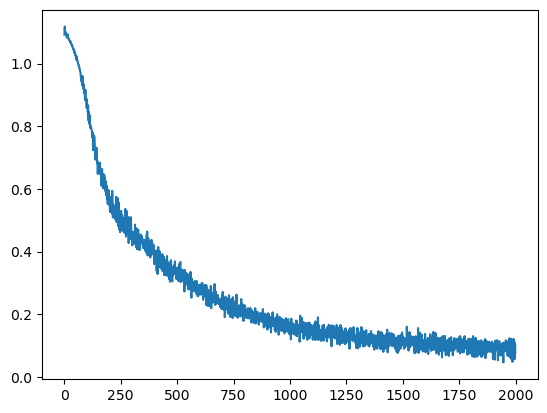

In [208]:
plt.plot(loss_list)